아래 그래프는 과거대출의 계약상태를 나타내는 변수를 비교한 것으로 전체횟수에서 거절된 횟수의 비중을 나타냅니다<br>
상환(target 0)인 경우 해당변수가 0에 몰려있으나, 미상환인 경우에는 0에 있는 비중이 상대적으로 낮고 거절비중이 좀 더 높습니다<br>
과거대출을 신청했을때 거절된 비율이 높을수록, 대출기준을 만족하지 못함, 현재대출을 상환하지 못할 확률도 높게나타난다고 설명할 수 있습니다<br>

The correlation between previous_loans_NAME_CONTRACT_STATUS_Refused_count_norm and the TARGET is 0.0777
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


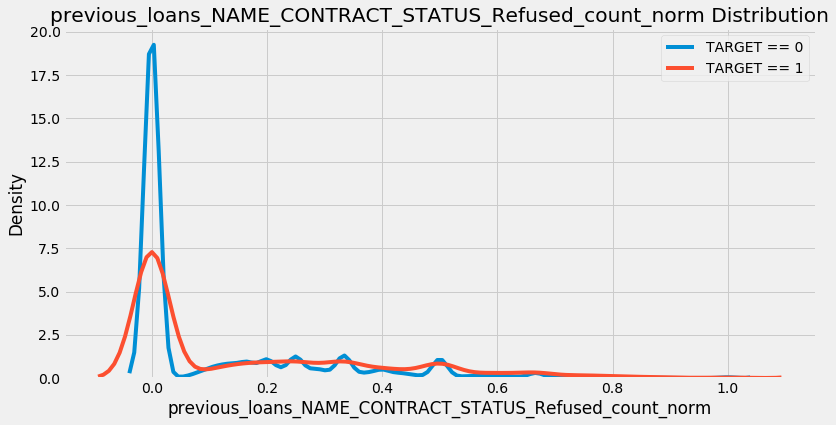

In [96]:
kde_target(var_name='previous_loans_NAME_CONTRACT_STATUS_Refused_count_norm', df=train)

### Logistic Regression Model

모델을 수행하기전에 결측치를 채우고, 특성들을 scaling 하는 전처리 작업을 수행합니다<br>
scikit-learn에 있는 LogisticRegression 모델을 사용합니다<br>

In [30]:
from sklearn.preprocessing import MinMaxScaler, Imputer

if 'TARGET' in app_train:
    train = app_train.drop(columns= ['TARGET'])
else :
    train = app_train.copy()
    
features = list(train.columns)

test = app_test.copy()
imputer = Imputer(strategy='median')
scaler = MinMaxScaler(feature_range=(0,1))
imputer.fit(train)

train = imputer.transform(train)
test = imputer.transform(app_test)

scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Training data shape:  (307511, 239)
Testing data shape:  (48744, 239)


In [31]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C= 0.0001)
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

regularization parameter, C를 디폴트값보다 낮게 설정하였다 해당값이 낮을수록 overfitting을 낮추는 기능을 합니다<br><br>

우리는 상환하지 않을 확률을 예측하는 것이 목표이기에 predict.proba 메서드를 사용했습니다<br>
m * 2 배열 형태로 결과값이 나오고 첫번째 컬럼은 상환할 확률(target 0), 두번째 컬럼은 미상환할 확률(target 1)을 나타냅니다

In [32]:
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [33]:
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred
submit.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,SK_ID_CURR,TARGET
0,100001,0.087895
1,100005,0.163376
2,100013,0.110105
3,100028,0.076499
4,100038,0.155235


### LightGBM

그래디언트 부스팅은 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가합니다. 이전 예측기가 만든 잔여오차에 새로운 예측기를 학습하는 방식입니다.<br><br>

모델에 들어갈 다양한 변수들을 생성하기 위해 공통함수로 다음 3개를 이용했습니다<br>
agg_numeric (수치형 데이터에서 count, mean, max, min, sum 기본통계를 계산)<br>
count_categorical (범주형 데이터에서 counts and normalized counts 계산)<br>
aggregate_client ( agg_numeric(), count_categorical() 두 개 함수를 이용하여 데이터셋을 정리)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
import gc

from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from lightgbm import LGBMClassifier

In [2]:
def agg_numeric(df, group_var, df_name):
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
    columns = [group_var]

    for var in agg.columns.levels[0]:
        if var != group_var:
            for stat in agg.columns.levels[1][:-1]:
                columns.append('%s_%s_%s' % (df_name, var, stat))
    agg.columns = columns
    return agg

In [3]:
def count_categorical(df, group_var, df_name):
    categorical = pd.get_dummies(df.select_dtypes('object'))
    categorical[group_var] = df[group_var]
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    column_names = []

    for var in categorical.columns.levels[0]:
        for stat in ['count', 'count_norm']:
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    return categorical

In [4]:
def aggregate_client(df, group_vars, df_names):
    
    df_agg = agg_numeric(df, group_var = group_vars[0], df_name = df_names[0])
    
    if any(df.dtypes == 'object'):
        df_counts = count_categorical(df, group_var = group_vars[0], df_name = df_names[0])
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')
        gc.enable()
        del df_agg, df_counts
        gc.collect()

        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        df_by_client = agg_numeric(df_by_loan, group_var = group_vars[1], df_name = df_names[1])
       
    else:
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        gc.enable()
        del df_agg
        gc.collect()
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        df_by_client = agg_numeric(df_by_loan, group_var = group_vars[1], df_name = df_names[1])
        
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

build_model_input()에서 각각의 데이터셋별로 키값을 중심으로 train, test 데이터셋과 merge 하는 작업을 진행합니다

In [11]:
def build_model_input():    

    print('Read data and test')
    train = pd.read_csv('../4th_week/data/application_train.csv')
    test = pd.read_csv('../4th_week/data/application_test.csv')
    print('Shapes : ', train.shape, test.shape)
    
    y = train['TARGET']
    del train['TARGET']  
    
    categorical_feats = [
        f for f in train.columns if train[f].dtype == 'object'
    ]
    categorical_feats
    for f_ in categorical_feats:
        train[f_], indexer = pd.factorize(train[f_])
        test[f_] = indexer.get_indexer(test[f_])
    
    print('Read bureau_balance')
    buro_bal = pd.read_csv('../4th_week/data/bureau_balance.csv')
    buro_bal = pd.concat([buro_bal, pd.get_dummies(buro_bal.STATUS, prefix='buro_bal_status')], axis=1).drop('STATUS', axis=1)
    buro_counts = buro_bal[['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby('SK_ID_BUREAU').count()
    buro_bal['buro_count'] = buro_bal['SK_ID_BUREAU'].map(buro_counts['MONTHS_BALANCE'])

    avg_buro_bal = buro_bal.groupby('SK_ID_BUREAU').mean()
    avg_buro_bal.columns = ['avg_buro_' + f_ for f_ in avg_buro_bal.columns]
    
    del buro_bal
    gc.collect()

    print('Read Bureau')
    buro = pd.read_csv('../4th_week/data/bureau.csv')
    buro_credit_active_dum = pd.get_dummies(buro.CREDIT_ACTIVE, prefix='ca_')
    buro_credit_currency_dum = pd.get_dummies(buro.CREDIT_CURRENCY, prefix='cu_')
    buro_credit_type_dum = pd.get_dummies(buro.CREDIT_TYPE, prefix='ty_')
    buro_full = pd.concat([buro, buro_credit_active_dum, buro_credit_currency_dum, buro_credit_type_dum], axis=1)
 
    del buro_credit_active_dum, buro_credit_currency_dum, buro_credit_type_dum
    gc.collect()

    print('Merge with buro avg')
    buro_full = buro_full.merge(right=avg_buro_bal.reset_index(), how='left', on='SK_ID_BUREAU', suffixes=('', '_bur_bal'))

    print('Counting buro per SK_ID_CURR')
    nb_bureau_per_curr = buro_full[['SK_ID_CURR', 'SK_ID_BUREAU']].groupby('SK_ID_CURR').count()
    buro_full['SK_ID_BUREAU'] = buro_full['SK_ID_CURR'].map(nb_bureau_per_curr['SK_ID_BUREAU'])

    print('Averaging bureau')
    bureau_by_client = buro_full.groupby('SK_ID_CURR').mean()

    del buro, buro_full
    gc.collect()

    train = train.merge(bureau_by_client, on = 'SK_ID_CURR', how = 'left')
    test = test.merge(bureau_by_client, on = 'SK_ID_CURR', how = 'left')
    
    gc.enable()
    del bureau_by_client
    gc.collect()
    
    print('Read prev')
    previous = pd.read_csv('../4th_week/data/previous_application.csv')
    previous_by_client = aggregate_client(previous, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['previous', 'client'])
    
    train = train.merge(previous_by_client, on = 'SK_ID_CURR', how = 'left')
    test = test.merge(previous_by_client, on = 'SK_ID_CURR', how = 'left')
    
    gc.enable()
    del previous, previous_by_client
    gc.collect()
        
    print('Reading POS_CASH')
    cash = pd.read_csv('../4th_week/data/POS_CASH_balance.csv')
    cash_by_client = aggregate_client(cash, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
    
    train = train.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
    test = test.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')

    gc.enable()
    del cash, cash_by_client
    gc.collect()
    
    print('Reading CC balance')
    credit = pd.read_csv('../4th_week/data/credit_card_balance.csv')
    credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])

    train = train.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
    test = test.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
    
    gc.enable()
    del credit, credit_by_client
    gc.collect()
    
    print('Reading Installments')
    installments = pd.read_csv('../4th_week/data/installments_payments.csv')
    installments_by_client = aggregate_client(installments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
    
    train = train.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
    test = test.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')

    gc.enable()
    del installments, installments_by_client
    gc.collect()
        
    return train, test, y

train_model()에서는 lightgbm의 LGBMClassifier에 복수의 test set을 준비하는 KFold (여기서는 5Fold)를 사용하여 모델을 훈련시킵니다

In [6]:
def train_model(data_, test_, y_, folds_):

    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    
    feature_importance_df = pd.DataFrame()
    
    feats = [f for f in data_.columns if f not in ['SK_ID_CURR']]
    
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            subsample_freq=1,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            random_state=0,
            silent=-1,
            verbose=-1, )
        
        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=100, early_stopping_rounds=200  #100
               )

        oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['TARGET'] = sub_preds

    return oof_preds, test_[['SK_ID_CURR', 'TARGET']], feature_importance_df

In [7]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances_0729.png')

Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.754941	valid_1's auc: 0.742518
[200]	training's auc: 0.781215	valid_1's auc: 0.762854
[300]	training's auc: 0.799578	valid_1's auc: 0.774897
[400]	training's auc: 0.81181	valid_1's auc: 0.7807
[500]	training's auc: 0.821312	valid_1's auc: 0.783602
[600]	training's auc: 0.829364	valid_1's auc: 0.785406
[700]	training's auc: 0.837012	valid_1's auc: 0.786683
[800]	training's auc: 0.843534	valid_1's auc: 0.787354
[900]	training's auc: 0.849542	valid_1's auc: 0.787968
[1000]	training's auc: 0.855169	valid_1's auc: 0.788204
[1100]	training's auc: 0.860966	valid_1's auc: 0.788534
[1200]	training's auc: 0.866158	valid_1's auc: 0.788726
[1300]	training's auc: 0.871372	valid_1's auc: 0.788617
Early stopping, best iteration is:
[1184]	training's auc: 0.865398	valid_1's auc: 0.788746
Fold  1 AUC : 0.788746
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.754358	valid_1's auc

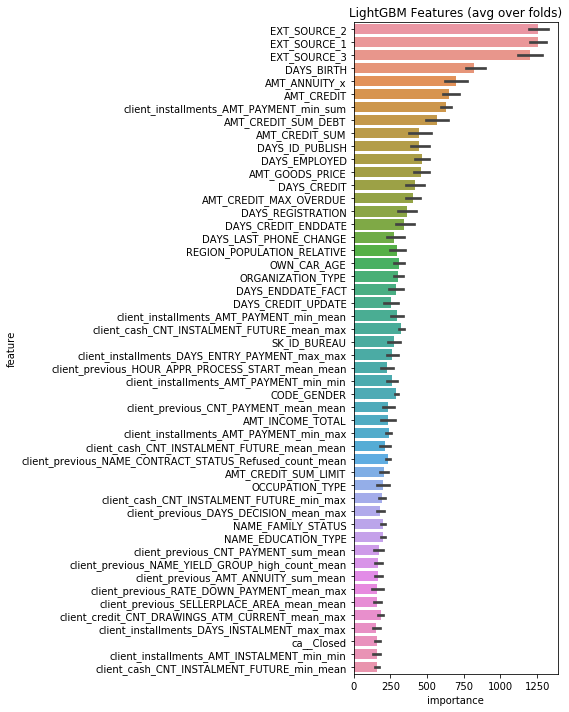

In [16]:
if __name__ == '__main__':
    gc.enable()
    data, test, y = build_model_input()
    folds = KFold(n_splits=5, shuffle=True, random_state=546789)
    oof_preds, test_preds, importances = train_model(data, test, y, folds)
    test_preds.to_csv('lightGBM_aggregate_0729.csv', index=False)
    folds_idx = [(trn_idx, val_idx) for trn_idx, val_idx in folds.split(data)]
    display_importances(feature_importance_df_=importances)

모델 훈련결과 0.787044 로 비교적 높은 결과값이 나왔습니다<br>
display_importances() 함수를 사용해서 모델에 미치는 영향력이 높은 상위50개 특성을 display 해보았습니다<br>
중요도가 높게 나온 특성중에 유의미한 것이 있다면 다시 이부분을 더 뜯어봐야 할 것 같습니다<br>